# 지점별로 선형모델 생성하기

In [1]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import os
import pandas as pd

In [2]:
tf.__version__

'2.10.1'

## 1-1 입출력 데이터셋 준비

In [3]:
pwd

'd:\\연구\\RnD_Ensemble\\GA'

### 예측 데이터 concat, label 설정

In [4]:
def concat_by_month(directory_path):
    """
    CSV 파일을 읽어와 월별로 데이터를 분류하고 병합
    모든 월의 데이터를 하나의 데이터프레임으로 return, 각 행은 월 정보를 포함

    :param directory_path: CSV 파일이 저장된 디렉토리 경로
    :return: 하나의 데이터프레임으로 병합된 월별 데이터
    """
    # 파일 목록을 읽어온다
    file_list = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 월별 데이터를 저장할 딕셔너리 초기화
    monthly_data = {str(i): [] for i in range(1, 13)}

    # 파일명에서 날짜를 파싱하여 해당 월에 맞는 데이터 프레임 리스트에 추가
    for file_name in file_list:
        date_part = file_name.split('_')[4]  # '20220614' 형식의 문자열 추출
        month = date_part[4:6]  # 월 정보 추출
        
        if month[0] == '0':
            month = month[1]  # '01'과 같은 경우 '1'로 변환
        
        # 파일 읽기
        file_path = os.path.join(directory_path, file_name)
        df = pd.read_csv(file_path)
        df = df[:-1]
        df['Month'] = month  # 월 정보를 데이터프레임에 추가

        # 해당 월에 데이터프레임 추가
        monthly_data[month].append(df)
        
    # 모든 월별 데이터를 하나의 데이터프레임으로 병합
    month_order = ['6', '7', '8', '9', '10', '11', '12', '1', '2', '3', '4', '5']
    all_months_df = pd.concat([pd.concat(monthly_data[month], ignore_index=True) for month in month_order if monthly_data[month]], ignore_index=True)
    
    return all_months_df

In [5]:
month_df = concat_by_month('../../RnD_new/south3')

### 관측데이터 label 설정

In [6]:
def create_month_column(filename):
    """
    현재 디렉토리에서 지정된 파일을 읽어 'obs_time' 열을 파싱하여 월 정보를 추출하고
    새로운 'Month' 열을 데이터프레임에 추가한 후 반환합니다.

    :param filename: 읽을 파일의 이름
    :return: 'Month' 열이 추가된 데이터프레임
    """
    # 현재 디렉토리 경로 설정
    current_directory = os.getcwd()
    # 파일 경로 완성
    file_path = os.path.join(current_directory, filename)
    
    # 파일이 존재하는지 확인
    if os.path.exists(file_path):
        # 파일 읽기
        df = pd.read_csv(file_path)
        # 'obs_time' 열이 있는지 확인 후 처리
        if 'obs_time' in df.columns:
            # 'obs_time' 열에서 날짜를 파싱하여 월 정보 추출
            df['Month'] = pd.to_datetime(df['obs_time']).dt.month
            return df
        else:
            raise ValueError("The file does not contain an 'obs_time' column.")
    else:
        raise FileNotFoundError("The specified file does not exist in the current directory.")

# 사용 예:
# filename = 'your_data.csv'
# updated_data = create_month_column_from_obs_time(filename)
# print(updated_data.head())  # 'obs_time'과 'Month' 열을 포함하는 데이터프레임 출력


In [7]:
obs_df = create_month_column('../south_obs_KG_0025.csv')

### 입출력 데이터 프레임 생성

In [8]:
obs_df.columns

Index(['obs_time', 'obs_u', 'obs_v', 'Month'], dtype='object')

In [9]:
month_df.columns

Index(['model_fct', 'model_u', 'model_v', 'Month'], dtype='object')

In [10]:
def create_input_output_data(df_obs, df_pred, start_date, end_date):
    """
    파라미터:
    - df_obs (pd.DataFrame): 관측 데이터를 포함하는 데이터프레임
    - df_pred (pd.DataFrame): 예측 데이터를 포함하는 데이터프레임
    - start_date (str 또는 pd.Timestamp): 데이터 선택을 시작할 날짜 ('YYYY-MM-DD' 형식).
    - end_date (str 또는 pd.Timestamp): 데이터 선택을 종료할 날짜 ('YYYY-MM-DD' 형식).

    반환 값:
    - input_df (pd.DataFrame): 관측값과 예측값이 결합된 (96시간씩) 데이터 프레임
    - output_df (pd.DataFrame): 관측 데이터 (48시간씩) 출력 데이터 프레임
    """
    
    # 시간 열을 datetime 형식으로 변환
    df_obs['obs_time'] = pd.to_datetime(df_obs['obs_time'])
    df_pred['obs_time'] = pd.to_datetime(df_pred['model_fct']) # model_fct를 통일성을 위해 obs_time 이름으로 사용
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # input, ouput dataframes
    input_frames = []
    output_frames = []
    
    start_index = 0
    start_index2 = 0
    # 날짜별로 데이터 프레임 구성
    for single_date in pd.date_range(start_date, end_date):
        
        # 관측값은 전일 0h-23h만 선택

        # 시작 인덱스로부터 24개의 행을 슬라이싱
        obs_data_yesterday = df_obs.loc[start_index:start_index + 23, ['obs_time', 'obs_u', 'obs_v']].copy()
        obs_data_yesterday.rename(columns={'obs_u': 'u', 'obs_v': 'v'}, inplace=True)
        
        start_index += 24
        # 'type' 컬럼을 추가하고 'obs'로 설정 (데이터 확인용)
        obs_data_yesterday['type'] = 'obs'
        
        # 예측값은 당일에서 24~71h 후
        # single_date에 해당하는 인덱스를 찾기

        # 시작 인덱스로부터 72개의 행을 슬라이싱
        pred_data_range = df_pred.loc[start_index2:start_index2 + 71, ['obs_time', 'model_u', 'model_v']].copy()
        start_index2 += 72
        
        # 열 이름 변경 및 'type' 컬럼 추가 (데이터 확인용)
        pred_data_range.rename(columns={'model_u': 'u', 'model_v': 'v'}, inplace=True)
        pred_data_range['type'] = 'model'
        if not pred_data_range.empty and len(pred_data_range) >= 25:
            month_value = pred_data_range['obs_time'].iloc[24].month
            pred_data_range['month'] = int(month_value)
            obs_data_yesterday['month'] = int(month_value)
        elif not pred_data_range.empty:
            pred_data_range['month'] = pred_data_range['obs_time'].dt.month.iloc[0]
        else:
            continue  # 데이터가 없으면 이번 루프는 건너뛰기
        
        # input 데이터는 관측값과 예측값을 병합 (관측치 24시간 + 예측치 72시간)
        combined_input = pd.concat([obs_data_yesterday, pred_data_range])

        
        # output 데이터는 다음날 24h부터 내일 모레까지 71h의 관측값
        output_data = df_obs[
            (df_obs['obs_time'] >= single_date + pd.DateOffset(days=1)) & 
            (df_obs['obs_time'] < single_date + pd.DateOffset(days=3))
        ][['obs_time', 'obs_u', 'obs_v']].copy()
        output_data.rename(columns={'obs_u': 'u', 'obs_v': 'v'}, inplace=True)
        output_data['month'] = output_data['obs_time'].iloc[0].month

        
        input_frames.append(combined_input)
        output_frames.append(output_data)

    
    input_df = pd.concat(input_frames, ignore_index=True)
    output_df = pd.concat(output_frames, ignore_index=True)
    
    # 모든 데이터 프레임에서 'obs_time' 열 이름을 'time'으로 변경
    input_df.rename(columns={'obs_time': 'time'}, inplace=True)
    output_df.rename(columns={'obs_time': 'time'}, inplace=True)

    return input_df, output_df


In [11]:
# 입력 및 출력 데이터 생성
input_df, output_df = create_input_output_data(obs_df, month_df, '2022-06-01', '2023-05-31')

### 96(192), 48(96)개씩 데이터 잘라서 입출력 생성

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
# 시간, u,v, month 열만 사용
input = input_df[['time', 'u', 'v', 'month']]
output = output_df[['time', 'u', 'v', 'month']]

In [14]:
# time열을 input, ouput 데이터프레임의 인덱스로 지정
columns = ['u', 'v', 'month']

input_feat = input_df[columns]
input_feat.index = input_df['time']

output_feat = output_df[columns]
output_feat.index = output_df['time']

In [15]:
# DataFrame을 numpy 배열로 변환
input_array = input_feat.values
output_array = output_feat.values

In [16]:
# 배열별로 결측치 세기
nan_count_in_input = np.sum(np.isnan(input_array))
nan_count_in_output = np.sum(np.isnan(output_array))

In [17]:
nan_count_in_input

868

In [18]:
nan_count_in_output

1774

In [19]:
input_array.shape

(34848, 3)

In [20]:
output_array.shape

(17424, 3)

In [21]:
len(input_array)

34848

In [22]:
len(output_array)

17424

### 샘플 생성 및 nan 제거

In [23]:
def simple_slice_data(input_data, output_data, input_window, output_window):
    """
    파라미터:
    - input_data (np.array): 모델 입력을 위한 원본 데이터 배열
    - output_data (np.array): 모델 출력(예측 대상)을 위한 원본 데이터 배열
    - input_window (int): 한 번에 입력으로 사용할 데이터 포인트의 수
    - output_window (int): 한 번에 출력으로 사용할 데이터 포인트의 수

    반환 값:
    - X (np.array): 입력 데이터 슬라이스의 배열.
    - y (np.array): 출력 데이터 슬라이스의 배열.
    """
    
    X = []
    y = []

    # 데이터셋의 최대 인덱스를 계산
    max_index = len(output_data) // 48
    print("max_index: {}".format(max_index))
    
    for i in range(max_index):
        
        # 입출력 데이터 슬라이스
        input_slice = input_data[i * input_window: (i + 1) * input_window]
        output_slice = output_data[i * output_window: (i + 1) * output_window]

        X.append(input_slice)
        y.append(output_slice)

    # 배열로 변환
    X = np.array(X)
    y = np.array(y)

    return X, y


In [24]:
# 입력은 96개씩 행이 한 샘플, 출력은 48개씩 행이 한 샘플 (하루치)
input_window = 96
output_window = 48
X, y = simple_slice_data(input_array, output_array, input_window, output_window)

print("X shape:", X.shape)  # (N, 96, 3)
print("y shape:", y.shape)  # (N, 48, 3)

max_index: 363
X shape: (363, 96, 3)
y shape: (363, 48, 3)


In [25]:
# 입출력에 있는 결측치 세기
X_nan = np.sum(np.isnan(X))
y_nan = np.sum(np.isnan(y))

In [26]:
X_nan

868

In [27]:
y_nan

1774

In [28]:
len(X)

363

In [29]:
len(y)

363

In [30]:
# 입력 데이터에서 결측치 위치 찾기
nan_indices_input = np.unique(np.where(np.isnan(X))[0])
nan_indices_input

array([  0,   6,   7,  17,  19,  30,  35,  40,  44,  45,  46,  52,  65,
        81,  82, 107, 111, 112, 121, 122, 123, 124, 135, 140, 141, 147,
       150, 166, 167, 178, 188, 200, 203, 207, 208, 224, 225, 226, 265,
       300, 318, 319, 320, 322, 332, 338, 339, 340, 349, 351], dtype=int64)

In [31]:
# 출력 데이터에서 결측치 위치 찾기
nan_indices_output = np.unique(np.where(np.isnan(y))[0])
nan_indices_output

array([  4,   5,   6,  15,  16,  17,  18,  28,  29,  33,  34,  38,  39,
        42,  43,  44,  45,  50,  51,  63,  64,  79,  80,  81, 105, 106,
       109, 110, 111, 119, 120, 121, 122, 123, 133, 134, 138, 139, 140,
       145, 146, 148, 149, 164, 165, 166, 176, 177, 186, 187, 198, 199,
       201, 202, 205, 206, 207, 222, 223, 224, 225, 263, 264, 298, 299,
       316, 317, 318, 319, 320, 321, 330, 331, 336, 337, 338, 339, 347,
       348, 349, 350, 361, 362], dtype=int64)

In [32]:
# 두 배열을 합쳐서 중복된 값 제거
common_nan_indices = np.unique(np.concatenate([nan_indices_input, nan_indices_output]))

In [33]:
nan_indices_input

array([  0,   6,   7,  17,  19,  30,  35,  40,  44,  45,  46,  52,  65,
        81,  82, 107, 111, 112, 121, 122, 123, 124, 135, 140, 141, 147,
       150, 166, 167, 178, 188, 200, 203, 207, 208, 224, 225, 226, 265,
       300, 318, 319, 320, 322, 332, 338, 339, 340, 349, 351], dtype=int64)

In [34]:
nan_indices_output

array([  4,   5,   6,  15,  16,  17,  18,  28,  29,  33,  34,  38,  39,
        42,  43,  44,  45,  50,  51,  63,  64,  79,  80,  81, 105, 106,
       109, 110, 111, 119, 120, 121, 122, 123, 133, 134, 138, 139, 140,
       145, 146, 148, 149, 164, 165, 166, 176, 177, 186, 187, 198, 199,
       201, 202, 205, 206, 207, 222, 223, 224, 225, 263, 264, 298, 299,
       316, 317, 318, 319, 320, 321, 330, 331, 336, 337, 338, 339, 347,
       348, 349, 350, 361, 362], dtype=int64)

In [35]:
# 두 배열을 합쳐서 중복된 값 제거
common_nan_indices = np.unique(np.concatenate([nan_indices_input, nan_indices_output]))

In [36]:
# input, output 샘플에서 통째로 날려야하는 n번째 샘플들
len(common_nan_indices)

113

In [37]:
common_nan_indices

array([  0,   4,   5,   6,   7,  15,  16,  17,  18,  19,  28,  29,  30,
        33,  34,  35,  38,  39,  40,  42,  43,  44,  45,  46,  50,  51,
        52,  63,  64,  65,  79,  80,  81,  82, 105, 106, 107, 109, 110,
       111, 112, 119, 120, 121, 122, 123, 124, 133, 134, 135, 138, 139,
       140, 141, 145, 146, 147, 148, 149, 150, 164, 165, 166, 167, 176,
       177, 178, 186, 187, 188, 198, 199, 200, 201, 202, 203, 205, 206,
       207, 208, 222, 223, 224, 225, 226, 263, 264, 265, 298, 299, 300,
       316, 317, 318, 319, 320, 321, 322, 330, 331, 332, 336, 337, 338,
       339, 340, 347, 348, 349, 350, 351, 361, 362], dtype=int64)

In [38]:
# input보다 큰 샘플 개수 삭제
valid_indices = common_nan_indices[common_nan_indices < len(X)]

In [39]:
len(valid_indices)

113

In [40]:
# input, ouput에서 common_nan_indices에 나열된 인덱스의 샘플들을 삭제
cleaned_X = np.delete(X, valid_indices, axis=0)
cleaned_y = np.delete(y, valid_indices, axis=0)

# 제거되고 남은 샘플 개수 확인
print(cleaned_X.shape)
print(cleaned_y.shape)

(250, 96, 3)
(250, 48, 3)


In [41]:
# 배열 전체에서 NaN 값 확인
nan_exists = np.isnan(cleaned_y).any()

In [42]:
nan_exists

False

In [43]:
print(cleaned_X.shape)

(250, 96, 3)


In [44]:
cleaned_y.shape

(250, 48, 3)

In [45]:
import numpy as np
import pandas as pd

# cleaned_X_reshaped와 cleaned_y_reshaped 배열이 주어졌다고 가정
# 예시 데이터 생성을 위한 코드는 생략합니다. 실제 데이터 사용을 가정

# 각 시간 단계를 별도의 행으로 변환하고, 열은 u, v, month로 설정
# cleaned_X_reshaped.reshape(-1, 3)는 모든 시간 단계를 행으로, 특성을 열로 펼칩니다.
df_X = pd.DataFrame(cleaned_X.reshape(-1, 3), columns=['u', 'v', 'month'])
df_y = pd.DataFrame(cleaned_y.reshape(-1, 3), columns=['u', 'v', 'month'])

# 'month' 열을 정수형으로 변환
df_X['month'] = df_X['month'].astype(int)
df_y['month'] = df_y['month'].astype(int)

# DataFrame을 CSV 파일로 저장
df_X.to_csv("X.csv", index=False)
df_y.to_csv("y.csv", index=False)

# 저장된 파일 확인 메시지
print("Data has been saved to cleaned_X_reshaped.csv and cleaned_y_reshaped.csv.")


Data has been saved to cleaned_X_reshaped.csv and cleaned_y_reshaped.csv.


## 월별인덱스 확인 및 정규화

In [46]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Reshape

In [47]:
# 월별로 인덱스를 분할할 리스트 초기화
monthly_indices = [[] for _ in range(12)]

total = 0
# 월별로 인덱스를 분할
for month in range(1, 13):
    indices = [i for i in range(cleaned_y.shape[0]) if int(cleaned_y[i, 0, 2]) == month]
    
    # 중복 제거 및 리스트로 변환
    total += len(indices)
    print("{0}월의 인덱스: {1}".format(month, indices))
    print("{0}월의 인덱스 개수: {1}".format(month,len(indices)))
    print('================================')
    monthly_indices[month-1].append(indices)

print("전체 index 개수: {}개".format(total))

# K-폴드 교차 검증 설정
kf = KFold(n_splits=12)

1월의 인덱스: [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158]
1월의 인덱스 개수: 26
2월의 인덱스: [159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183]
2월의 인덱스 개수: 25
3월의 인덱스: [184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211]
3월의 인덱스 개수: 28
4월의 인덱스: [212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231]
4월의 인덱스 개수: 20
5월의 인덱스: [232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249]
5월의 인덱스 개수: 18
6월의 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
6월의 인덱스 개수: 18
7월의 인덱스: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
7월의 인덱스 개수: 15
8월의 인덱스: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
8월의 인덱스 개수: 

## feature 4로 X 분리

In [48]:
# 각 24시간 구간을 4개의 feature로 나누기 위해 reshape
# (batch_size, total_time_steps, features) -> (batch_size, 4, time_steps_per_feature, original_features)
reshaped_X = cleaned_X.reshape((cleaned_X.shape[0], 4, 24, cleaned_X.shape[2]))

# 각 시간 구간별로 feature명을 지정하고 데이터프레임으로 변환 후 numpy 배열로 변환
numpy_arrays = []
for i in range(reshaped_X.shape[1]):  # 4개의 24시간 구간
    data = reshaped_X[:, i, :, :].reshape(-1, reshaped_X.shape[3])
    df = pd.DataFrame(data, columns=[f"feature_{j+1}" for j in range(reshaped_X.shape[3])])
    numpy_array = df.to_numpy()  # 데이터프레임을 numpy 배열로 변환
    numpy_arrays.append(numpy_array)
    print(f"Numpy array for time segment {i+1}:")
    print(numpy_array)
    print("\n")

# 각 시간 구간에 대한 numpy 배열
feature1, feature2, feature3, feature4 = numpy_arrays

# feature들을 24시간씩 잘라서 (sample_size, 24, 3) 형태로 변환
def reshape_features(feature):
    num_samples = feature.shape[0] // 24
    reshaped_feature = feature[:num_samples * 24].reshape(num_samples, 24, feature.shape[1])
    return reshaped_feature

feature1 = reshape_features(feature1)
feature2 = reshape_features(feature2)
feature3 = reshape_features(feature3)
feature4 = reshape_features(feature4)

Numpy array for time segment 1:
[[ 3.99939078 -0.06980963  6.        ]
 [ 3.2874425   0.28761395  6.        ]
 [ 4.10821992  0.8732291   6.        ]
 ...
 [ 1.48467696  6.43084243  5.        ]
 [ 1.63055998  6.08533271  5.        ]
 [ 2.00686052  5.22805039  5.        ]]


Numpy array for time segment 2:
[[ 3.43869  1.23156  6.     ]
 [ 3.32552  0.90594  6.     ]
 [ 3.17408  0.99565  6.     ]
 ...
 [-0.52637  7.52456  5.     ]
 [-0.93307  7.42741  5.     ]
 [-1.13584  7.48273  5.     ]]


Numpy array for time segment 3:
[[ 4.73782 -1.1076   6.     ]
 [ 3.75431 -1.6791   6.     ]
 [ 3.44985 -0.57597  6.     ]
 ...
 [ 4.05969  5.01327  5.     ]
 [ 4.04926  4.85134  5.     ]
 [ 4.06316  4.74879  5.     ]]


Numpy array for time segment 4:
[[-6.58134 -3.784    6.     ]
 [-6.62279 -3.66107  6.     ]
 [-6.59888 -3.62452  6.     ]
 ...
 [-6.54109 -5.08182  5.     ]
 [-7.24673 -4.59872  5.     ]
 [-7.75655 -5.47585  5.     ]]




In [49]:
# 마지막 차원의 크기를 2로 변경 (예시로 첫 번째와 두 번째 feature만 사용)
reshaped_X = reshaped_X[:, :, :, :2]
reshaped_X.shape

(250, 4, 24, 2)

In [50]:
reshaped_X

array([[[[ 3.99939078, -0.06980963],
         [ 3.2874425 ,  0.28761395],
         [ 4.10821992,  0.8732291 ],
         ...,
         [ 5.04059954,  1.63779007],
         [ 4.77441332,  1.10226017],
         [ 4.91669659,  1.6929544 ]],

        [[ 3.43869   ,  1.23156   ],
         [ 3.32552   ,  0.90594   ],
         [ 3.17408   ,  0.99565   ],
         ...,
         [ 5.48861   ,  1.92101   ],
         [ 6.14056   ,  0.43412   ],
         [ 5.76438   , -0.68728   ]],

        [[ 4.73782   , -1.1076    ],
         [ 3.75431   , -1.6791    ],
         [ 3.44985   , -0.57597   ],
         ...,
         [-7.05158   , -3.26567   ],
         [-6.72481   , -3.0065    ],
         [-6.65626   , -3.39857   ]],

        [[-6.58134   , -3.784     ],
         [-6.62279   , -3.66107   ],
         [-6.59888   , -3.62452   ],
         ...,
         [-6.52077   ,  1.2598    ],
         [-6.9145    ,  1.9775    ],
         [-5.59783   ,  5.45467   ]]],


       [[[ 5.01124845,  1.72551122],
         

In [51]:
X = np.concatenate((feature1, feature2, feature3, feature4), axis=2)

In [52]:
X.shape

(250, 24, 12)

In [53]:
X = np.delete(X, [2,5,8,11], axis=2)

In [54]:
X.shape

(250, 24, 8)

In [55]:
X

array([[[ 3.99939078, -0.06980963,  3.43869   , ..., -1.1076    ,
         -6.58134   , -3.784     ],
        [ 3.2874425 ,  0.28761395,  3.32552   , ..., -1.6791    ,
         -6.62279   , -3.66107   ],
        [ 4.10821992,  0.8732291 ,  3.17408   , ..., -0.57597   ,
         -6.59888   , -3.62452   ],
        ...,
        [ 5.04059954,  1.63779007,  5.48861   , ..., -3.26567   ,
         -6.52077   ,  1.2598    ],
        [ 4.77441332,  1.10226017,  6.14056   , ..., -3.0065    ,
         -6.9145    ,  1.9775    ],
        [ 4.91669659,  1.6929544 ,  5.76438   , ..., -3.39857   ,
         -5.59783   ,  5.45467   ]],

       [[ 5.01124845,  1.72551122,  3.88661   , ..., -3.83717   ,
         -4.54737   ,  8.42679   ],
        [ 4.2693012 ,  1.06445634,  3.51361   , ..., -3.61621   ,
         -5.79549   ,  7.12265   ],
        [ 4.18976901,  0.29297719,  2.64009   , ..., -3.26899   ,
         -6.23703   ,  6.01121   ],
        ...,
        [-7.5481398 , -3.20399525, -6.60207   , ...,  

In [56]:
# 3번째 열을 제거
y_processed = cleaned_y[:, :, :2]

In [57]:
y_processed.shape

(250, 48, 2)

In [58]:
X.shape

(250, 24, 8)

# 2. 모델 성능 측정

## 시간대별 (24~71h) 데이터 정리 및 저장

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, PReLU, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
import itertools
from tensorflow.keras.initializers import glorot_normal
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU ,Lambda, Activation, Bidirectional
from keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
import warnings
from sklearn.svm import SVR

In [60]:
# 첫 번째 기본 모델
def build_regression_model(input_steps, features, output_steps, output_features):
    model = Sequential([
        Conv1D(filters=512, kernel_size=2, activation='tanh', padding='same', input_shape=(input_steps, features)),
        Dropout(0.4),
        Conv1D(filters=512, kernel_size=2, activation='tanh', padding='same'),
        Bidirectional(GRU(units=512, return_sequences=True, activation='tanh')),
        Dropout(0.4),
        Flatten(),
        Dense(units=1024, activation='selu'),
        Dropout(0.4),
        Dense(units=output_steps * output_features, activation='linear'),
        Reshape((output_steps, output_features))
    ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.8, nesterov=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model

# 두 번째 기본 모델
def build_regression_model2(input_steps, features, output_steps, output_features):
    # 입력 계층
    inputs = Input(shape=(input_steps, features))

    # 첫 번째 LSTM 계층
    x = LSTM(units=128, return_sequences=True, activation='tanh')(inputs)
    x = Dropout(0.4)(x)

    # 두 번째 LSTM 계층
    x = LSTM(units=64, return_sequences=False, activation='tanh')(x)
    x = Dropout(0.4)(x)

    # 출력 계층
    x = Dense(units=output_steps * output_features, activation='linear')(x)
    outputs = Reshape((output_steps, output_features))(x)

    # 모델 정의
    model = Model(inputs=inputs, outputs=outputs)

    # 최적화 및 컴파일
    optimizer = SGD(learning_rate=0.01, momentum=0.8, nesterov=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model

def build_regression_model3(input_steps, features, output_steps, output_features):
    model = Sequential([
                Input(shape=(input_steps, features)),
                Bidirectional(GRU(units=1024, return_sequences=False)),  # 양방향 LSTM 레이어
                Dropout(0.6),  # 드롭아웃 레이어
                Dense(units=1024, activation='elu'),  # 완전 연결 레이어 추가
                Dropout(0.4), 
                Dense(units=1024, activation='elu'),
                Dropout(0.4),
                Dense(units=1024, activation='elu'),
                Dropout(0.4),
                Dense(units=output_steps * output_features, activation='linear'),  # 출력 레이어
                Reshape((output_steps, output_features))  # 출력 형상 조정
            ])
    
    optimizer = SGD(learning_rate=0.01, momentum=0.8, nesterov=True)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model

def create_and_compile_model(input_shape=(192,), learning_rate=0.01, momentum=0.8, dropout_rate=0.6):
    """
    선형 모델을 생성하고 컴파일하는 함수

    Parameters:
    - input_shape: 입력 데이터의 형태 (기본값은 (192,))
    - learning_rate: SGD 옵티마이저의 학습률 (기본값은 0.01)
    - momentum: SGD 옵티마이저의 모멘텀 값 (기본값은 0.8)
    - dropout_rate: Dropout 레이어의 비율 (기본값은 0.6)

    Returns:
    - model: 컴파일된 Keras 모델
    """
    # 모델 생성
    model = Sequential([
        Input(shape=input_shape),
        Dense(1024, activation='selu'),
        Dropout(dropout_rate),
        Dense(96, activation='linear')
    ])

    # 옵티마이저 설정
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    # 모델 컴파일
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    
    return model



In [61]:
import numpy as np
import pandas as pd

def load_scaled_data_from_csv(file_path, input_steps, features):
    """
    CSV에서 2D 데이터를 로드한 뒤 3D로 변환합니다.
    """
    data_2d = pd.read_csv(file_path, header=None).values  # CSV 읽기
    data_3d = data_2d.reshape(-1, input_steps, features)  # 2D -> 3D 변환
    print(f"Data loaded from {file_path} and reshaped to {data_3d.shape}")
    return data_3d

In [62]:
def train_and_predict_svr_3d(X_train, y_train, X_val, X_test):
    """
    3차원 데이터를 2차원으로 변환하여 SVR 모델 학습 및 예측을 수행하고,
    다시 3차원 형태로 복원하는 함수
    """
    # 데이터 3차원 -> 2차원 변환
    n_samples, n_time, n_features = X_train.shape
    
    # 올바르게 2D 변환
    X_train_2d = X_train.reshape(n_samples,192)
    y_train_2d = y_train.reshape(n_samples,96)
    X_val_2d = X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
    X_test_2d = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

    # MultiOutputRegressor를 사용하여 다중 출력 SVR 모델 생성
    svr_model = MultiOutputRegressor(SVR(kernel='rbf', C=1.0, epsilon=0.1))
    print(X_train_2d.shape)
    # 모델 학습
    svr_model.fit(X_train_2d, y_train_2d)

    # 예측 수행
    y_val_pred_2d = svr_model.predict(X_val_2d)
    y_test_pred_2d = svr_model.predict(X_test_2d)

    # 예측 결과를 3차원으로 복원
    y_val_pred_3d = y_val_pred_2d.reshape(-1,48, 2)
    y_test_pred_3d = y_test_pred_2d.reshape(-1,48, 2)

    return svr_model, y_test_pred_3d, y_val_pred_3d


In [63]:
def train_and_predict_nn_3d(X_train, y_train, X_val, X_test, input_shape, learning_rate=0.01, momentum=0.8, dropout_rate=0.6):
    """
    3차원 데이터를 입력받아 NN 모델을 학습하고 예측을 수행한 후,
    3차원 형태로 반환하는 함수

    Parameters:
    - X_train: 훈련 데이터 (3차원: 샘플수, 시간, 특성수)
    - y_train: 훈련 라벨 (3차원: 샘플수, 시간, 특성수)
    - X_val: 검증 데이터 (3차원: 샘플수, 시간, 특성수)
    - X_test: 테스트 데이터 (3차원: 샘플수, 시간, 특성수)
    - input_shape: 입력 데이터의 형태 (3차원: 샘플수, 시간, 특성수)
    - learning_rate: SGD 옵티마이저의 학습률 (기본값은 0.01)
    - momentum: SGD 옵티마이저의 모멘텀 값 (기본값은 0.8)
    - dropout_rate: Dropout 레이어의 비율 (기본값은 0.6)

    Returns:
    - results: NN 모델의 예측 결과
    - trained_nn_model: 학습된 NN 모델
    """
    # 데이터 3차원 -> 2차원 변환
    n_samples, n_time, n_features = X_train.shape

    X_train_2d = X_train.reshape(n_samples, -1)
    y_train_2d = y_train.reshape(n_samples, -1)
    X_val_2d = X_val.reshape(X_val.shape[0], -1)
    X_test_2d = X_test.reshape(X_test.shape[0], -1)

    nn_model = Sequential([
        Input(shape=(192,)),
        Dense(1024, activation='elu'),
        Dropout(dropout_rate),
        Dense(96, activation='linear')
    ])

    optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    nn_model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    # Early Stopping 설정
    early_stopping = EarlyStopping(
        monitor='loss', 
        patience=30, 
        verbose=1, 
        restore_best_weights=True
    )

    # NN 모델 학습
    nn_model.fit(
        X_train_2d, y_train_2d,
        epochs=300, 
        batch_size=128, 
        verbose=1,
        callbacks=[early_stopping]
    )

    # NN 예측 수행
    y_val_pred_2d = nn_model.predict(X_val_2d)
    y_test_pred_2d = nn_model.predict(X_test_2d)

    # NN 예측 결과를 3차원으로 복원
    y_val_pred_3d = y_val_pred_2d.reshape(-1, 48, 2)
    y_test_pred_3d = y_test_pred_2d.reshape(-1, 48, 2)

    print(y_val_pred_3d.shape)
    print(y_test_pred_3d.shape)
    return nn_model, y_val_pred_3d, y_test_pred_3d

In [64]:
print(f"4월 데이터 크기 확인: {monthly_indices[3]}")


4월 데이터 크기 확인: [[212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231]]


In [65]:
# 빈 리스트 제거
for i in range(len(monthly_indices) - 1, -1, -1):  # 역순으로 순회
    if isinstance(monthly_indices[i], list) and all(len(inner) == 0 for inner in monthly_indices[i]):
        del monthly_indices[i]


In [66]:
len(monthly_indices)

12

In [67]:
from sklearn.preprocessing import MaxAbsScaler

from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import itertools
import csv
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import os

def ensemble_models(
    cleaned_X, cleaned_y, unique_monthly_indices,
    input_steps, features, output_steps, output_features,
    CONV_WIDTH, STRIDE, output_dir
):
    results_dict = {i: {'predictions': [], 'true_values': []} for i in range(output_steps)}
    fold_rmse_values = []

    early_stopping = EarlyStopping(
        monitor='loss',
        patience=30,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )

    os.makedirs(output_dir, exist_ok=True)

    for month in range(12):
        print(f"Processing Month {month + 1}")

        # 데이터 분할
        try:
            test_indices = unique_monthly_indices[month]
            validation_indices = unique_monthly_indices[(month + 1) % 12]
            train_indices = []

            for month_idx in range(12):
                if month_idx != month and month_idx != (month + 1) % 12:
                    train_indices.extend(unique_monthly_indices[month_idx])

            train_flatten_indices = list(itertools.chain(*train_indices))
            validation_flatten_indices = list(itertools.chain(*validation_indices))
            test_flatten_indices = list(itertools.chain(*test_indices))

            # 빈 데이터 확인
            if not train_flatten_indices or not validation_flatten_indices or not test_flatten_indices:
                print(f"{month + 1}월 데이터 확인: train={len(train_flatten_indices)}, val={len(validation_flatten_indices)}, test={len(test_flatten_indices)}")
                continue

            X_train = cleaned_X[train_flatten_indices, :, :]
            y_train = cleaned_y[train_flatten_indices, :, :]
            X_val = cleaned_X[validation_flatten_indices, :, :]
            y_val = cleaned_y[validation_flatten_indices, :, :]
            X_test = cleaned_X[test_flatten_indices, :, :]
            y_test = cleaned_y[test_flatten_indices, :, :]
        except IndexError:
            print(f"{month + 1}월: 데이터가 부족하여 건너뜁니다.")
            continue


        scaler = MaxAbsScaler()
        try:
            X_train_scaled_3d = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(-1, input_steps, features)
            X_val_scaled_3d = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(-1, input_steps, features)
            X_test_scaled_3d = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(-1, input_steps, features)
        except ValueError as e:
            print(f"스케일링 중 오류 발생: {e}")
            continue

        models = [
            build_regression_model(input_steps, features, output_steps, output_features),
            build_regression_model2(input_steps, features, output_steps, output_features),
            build_regression_model3(input_steps, features, output_steps, output_features)
        ]

        try:
            # SVR 모델 추가
            svr_model, svr_test_pred, svr_val_pred = train_and_predict_svr_3d(
                X_train_scaled_3d, y_train, X_val_scaled_3d, X_test_scaled_3d
            )
            models.append(svr_model)

            # NN 모델 추가
            nn_model, nn_val_pred_3d, nn_test_pred_3d = train_and_predict_nn_3d(
                X_train_scaled_3d, y_train, X_val_scaled_3d, X_test_scaled_3d,
                input_shape=(None, input_steps, features),
                learning_rate=0.01, momentum=0.8, dropout_rate=0.6
            )
            models.append(nn_model)
        except Exception as e:
            print(f"SVR 또는 NN 모델 생성 중 오류 발생: {e}")
            continue

        # 첫 번째 학습: 검증 데이터에 대한 예측 수행
        for i, model in enumerate(models[:-2]):
            print(f"Training Model {i + 1} (Validation Phase)")
            model.fit(
                X_train_scaled_3d, y_train,
                epochs=300,
                batch_size=128,
                callbacks=[early_stopping],
                verbose=1
            )


        model_predictions_val = [model.predict(X_val_scaled_3d) for model in models[:-2]]
        model_predictions_val.append(svr_val_pred)
        model_predictions_val.append(nn_val_pred_3d)

        output_csv_path_val = f"{output_dir}/results_month_{month + 1}_val.csv"
        with open(output_csv_path_val, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "Sample Index", "Time Step",
                "Model 1 Val Pred U", "Model 1 Val Pred V",
                "Model 2 Val Pred U", "Model 2 Val Pred V",
                "Model 3 Val Pred U", "Model 3 Val Pred V",
                "Model 4 Val Pred U", "Model 4 Val Pred V",
                "Model 5 Val Pred U", "Model 5 Val Pred V",
                "True U", "True V"
            ])

            for j in range(X_val_scaled_3d.shape[0]):
                y_val_sample = y_val[j, :, :]
                val_pred_samples = [pred[j, :, :] for pred in model_predictions_val]

                for t in range(output_steps):
                    writer.writerow([
                        j, t,
                        val_pred_samples[0][t, 0], val_pred_samples[0][t, 1],
                        val_pred_samples[1][t, 0], val_pred_samples[1][t, 1],
                        val_pred_samples[2][t, 0], val_pred_samples[2][t, 1],
                        val_pred_samples[3][t, 0], val_pred_samples[3][t, 1],
                        val_pred_samples[4][t, 0], val_pred_samples[4][t, 1],
                        y_val_sample[t, 0], y_val_sample[t, 1]
                    ])

        # 두 번째 학습: 테스트 데이터에 대한 예측 수행
        second_train_indices = []
        test_indices = unique_monthly_indices[month]  # month에 해당하는 테스트 데이터
        print("len!!!!!", len(test_indices))

        for month_idx in range(12):
            if month_idx != month:
                second_train_indices.extend(unique_monthly_indices[month_idx])

        second_train_flatten_indices = list(itertools.chain(*second_train_indices))
        test_indices = list(itertools.chain(*test_indices))
        print(len(test_indices)) # 여기까진 괜찮음

        # Validation 데이터를 20%로 분리
        train_indices, val_indices = train_test_split(
            second_train_flatten_indices, test_size=0.2, random_state=42
        )

        # 학습 데이터 (검증 데이터 제외)
        X_train_second = cleaned_X[train_indices, :, :]
        y_train_second = cleaned_y[train_indices, :, :]

        # 검증 데이터
        X_val_second = cleaned_X[val_indices, :, :]
        y_val_second = cleaned_y[val_indices, :, :]

        X_test_second = cleaned_X[test_indices, :, :]
        y_test_second = cleaned_y[test_indices, :, :]

        print(f"Test indices for month {month + 1}: {len(test_indices)}")
        # MaxAbsScaler 초기화
        scaler = MaxAbsScaler()

        # 학습 데이터: fit_transform
        X_train_scaled_3d_second = scaler.fit_transform(
            X_train_second.reshape(X_train_second.shape[0], -1)  # 2D로 변환
        ).reshape(-1, X_train_second.shape[1], X_train_second.shape[2])  # 3D로 복원

        # 검증 데이터: transform
        X_val_scaled_3d_second = scaler.transform(
            X_val_second.reshape(X_val_second.shape[0], -1)  # 2D로 변환
        ).reshape(-1, X_val_second.shape[1], X_val_second.shape[2])  # 3D로 복원

        # 테스트 데이터: transform
        X_test_scaled_3d_second = scaler.transform(
            X_test_second.reshape(X_test_second.shape[0], -1)  # 2D로 변환
        ).reshape(-1, X_test_second.shape[1], X_test_second.shape[2])  # 3D로 복원


        # 데이터 확인
        print(f"second Training data shape: {X_train_second.shape}")
        print(f"second Validation data shape: {X_val_second.shape}")
        print(f"second Test data shape: {X_test_second.shape}")

        for i, model in enumerate(models[:-2]):
            print(f"Training Model {i + 1} (Test Phase)")
            model.fit(
                X_train_scaled_3d_second, y_train_second,
                validation_data=(X_val_scaled_3d_second, y_val_second),  # 검증 데이터로만 사용
                epochs=300,
                batch_size=128,
                callbacks=[early_stopping],
                verbose=1
            )


        model_predictions_test_second = [model.predict(X_test_scaled_3d_second) for model in models[:-2]]
        model_predictions_test_second.append(svr_test_pred)
        model_predictions_test_second.append(nn_test_pred_3d)
        model_predictions_test_second = np.array(model_predictions_test_second)
        print(model_predictions_test_second.shape)

        output_csv_path_test = f"{output_dir}/results_month_{month + 1}_test.csv"
        with open(output_csv_path_test, "w", newline="", encoding="utf-8") as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow([
                "Sample Index", "Time Step",
                "Model 1 Test Pred U", "Model 1 Test Pred V",
                "Model 2 Test Pred U", "Model 2 Test Pred V",
                "Model 3 Test Pred U", "Model 3 Test Pred V",
                "Model 4 Test Pred U", "Model 4 Test Pred V",
                "Model 5 Test Pred U", "Model 5 Test Pred V",
                "True U", "True V"
            ])

            for j in range(model_predictions_test_second.shape[1]):
                y_test_sample = y_test[j, :, :]
                test_pred_samples = [pred[j, :, :] for pred in model_predictions_test_second]

                for t in range(output_steps):
                    writer.writerow([
                        j, t,
                        test_pred_samples[0][t, 0], test_pred_samples[0][t, 1],
                        test_pred_samples[1][t, 0], test_pred_samples[1][t, 1],
                        test_pred_samples[2][t, 0], test_pred_samples[2][t, 1],
                        test_pred_samples[3][t, 0], test_pred_samples[3][t, 1],
                        test_pred_samples[4][t, 0], test_pred_samples[4][t, 1],
                        y_test_sample[t, 0], y_test_sample[t, 1]
                    ])

        print(f"{month + 1}월 결과 완료")

    def calculate_rmse_with_weights(predictions, true_values, weights):
        """
        Calculate RMSE using weighted ensemble predictions.

        Parameters:
            predictions (list of np.array): List of model predictions (each shape: [samples, timesteps, features]).
            true_values (np.array): True values (shape: [samples, timesteps, features]).
            weights (list of float): List of weights for each model.

        Returns:
            float: RMSE value.
        """
        # Validate inputs
        if len(predictions) != len(weights):
            raise ValueError("Number of predictions and weights must be equal.")

        # Weighted ensemble prediction
        weighted_prediction = sum(weight * pred for weight, pred in zip(weights, predictions))

        # Flatten arrays for RMSE calculation
        weighted_prediction_flat = weighted_prediction.reshape(-1, weighted_prediction.shape[-1])
        true_values_flat = true_values.reshape(-1, true_values.shape[-1])

        # Calculate RMSE
        rmse = mean_squared_error(true_values_flat, weighted_prediction_flat, squared=False)
        return rmse

    # Example usage
    # Assume model_predictions_test_second and y_test are available from the ensemble training process
    model_predictions = model_predictions_test_second  # List of 5 model predictions (each [samples, timesteps, features])
    true_values = y_test  # True values ([samples, timesteps, features])

    # Assign equal weights of 0.2 for each model
    weights = [0.2] * len(model_predictions)

    # Calculate RMSE
    rmse = calculate_rmse_with_weights(model_predictions, true_values, weights)
    print(f"Ensemble RMSE with equal weights (0.2 each): {rmse}")


ensemble_models(X, y_processed, monthly_indices,24,8,48,2,2,1, './ga_s3')

Processing Month 1
(199, 192)
Epoch 1/300
2/2 [==============================] - 1s 9ms/step - loss: 28.6757 - mse: 28.6757
Epoch 2/300
2/2 [==============================] - 0s 4ms/step - loss: 27.8574 - mse: 27.8574
Epoch 3/300
2/2 [==============================] - 0s 4ms/step - loss: 26.6940 - mse: 26.6940
Epoch 4/300
2/2 [==============================] - 0s 3ms/step - loss: 25.3948 - mse: 25.3948
Epoch 5/300
2/2 [==============================] - 0s 3ms/step - loss: 24.0864 - mse: 24.0864
Epoch 6/300
2/2 [==============================] - 0s 3ms/step - loss: 22.5166 - mse: 22.5166
Epoch 7/300
2/2 [==============================] - 0s 3ms/step - loss: 21.1023 - mse: 21.1023
Epoch 8/300
2/2 [==============================] - 0s 3ms/step - loss: 19.6274 - mse: 19.6274
Epoch 9/300
2/2 [==============================] - 0s 3ms/step - loss: 17.9742 - mse: 17.9742
Epoch 10/300
2/2 [==============================] - 0s 3ms/step - loss: 16.7505 - mse: 16.7505
Epoch 11/300
2/2 [===========

c:\Users\dasap\anaconda3\envs\tf10\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [69]:
import pandas as pd
import os

# Define the columns for each output CSV
base_columns = ['Sample Index', 'Time Step']
val_model_columns = [
    ['Model 1 Val Pred U', 'Model 1 Val Pred V'],
    ['Model 2 Val Pred U', 'Model 2 Val Pred V'],
    ['Model 3 Val Pred U', 'Model 3 Val Pred V'],
    ['Model 4 Val Pred U', 'Model 4 Val Pred V'],
    ['Model 5 Val Pred U', 'Model 5 Val Pred V']
]

test_model_columns = [
    ['Model 1 Test Pred U', 'Model 1 Test Pred V'],
    ['Model 2 Test Pred U', 'Model 2 Test Pred V'],
    ['Model 3 Test Pred U', 'Model 3 Test Pred V'],
    ['Model 4 Test Pred U', 'Model 4 Test Pred V'],
    ['Model 5 Test Pred U', 'Model 5 Test Pred V']
]

# Add true values columns
true_values_columns = ['True U', 'True V']

# Function to split and save results data
def split_and_save(data, prefix, month, model_columns):
    for i, cols in enumerate(model_columns, start=1):
        # Combine base columns with model-specific columns and true values
        selected_columns = base_columns + cols + true_values_columns

        # Create a new dataframe with the selected columns
        model_data = data[selected_columns]

        # Define the folder for the model
        model_folder = f'ga_s3/model{i}'
        os.makedirs(model_folder, exist_ok=True)

        # Save to a new CSV file
        output_file = f'{model_folder}/{prefix}_month_{month}_model_{i}_results.csv'
        model_data.to_csv(output_file, index=False)
        print(f"Saved: {output_file}")

# Loop through months and process validation and test data
for month in range(1, 13):
    val_file = f'ga_s3/results_month_{month}_val.csv'
    test_file = f'ga_s3/results_month_{month}_test.csv'

    val_results_data = pd.read_csv(val_file)
    test_results_data = pd.read_csv(test_file)

    # Process validation data
    split_and_save(val_results_data, 'val', month, val_model_columns)

    # Process test data
    split_and_save(test_results_data, 'test', month, test_model_columns)


Saved: ga_s3/model1/val_month_1_model_1_results.csv
Saved: ga_s3/model2/val_month_1_model_2_results.csv
Saved: ga_s3/model3/val_month_1_model_3_results.csv
Saved: ga_s3/model4/val_month_1_model_4_results.csv
Saved: ga_s3/model5/val_month_1_model_5_results.csv
Saved: ga_s3/model1/test_month_1_model_1_results.csv
Saved: ga_s3/model2/test_month_1_model_2_results.csv
Saved: ga_s3/model3/test_month_1_model_3_results.csv
Saved: ga_s3/model4/test_month_1_model_4_results.csv
Saved: ga_s3/model5/test_month_1_model_5_results.csv
Saved: ga_s3/model1/val_month_2_model_1_results.csv
Saved: ga_s3/model2/val_month_2_model_2_results.csv
Saved: ga_s3/model3/val_month_2_model_3_results.csv
Saved: ga_s3/model4/val_month_2_model_4_results.csv
Saved: ga_s3/model5/val_month_2_model_5_results.csv
Saved: ga_s3/model1/test_month_2_model_1_results.csv
Saved: ga_s3/model2/test_month_2_model_2_results.csv
Saved: ga_s3/model3/test_month_2_model_3_results.csv
Saved: ga_s3/model4/test_month_2_model_4_results.csv
Sav

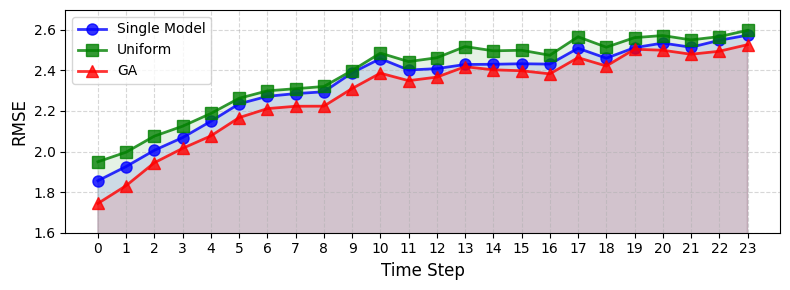

In [19]:
# Reimporting necessary libraries and rerunning the plot generation
import matplotlib.pyplot as plt
import numpy as np

# Data setup
time_steps = np.arange(24)

single_model = [1.8560, 1.9260, 2.0060, 2.0686, 2.1488, 2.2349, 2.2718, 2.2852, 2.2941, 2.3876,
                2.4573, 2.4014, 2.4081, 2.4286, 2.4296, 2.4322, 2.4304, 2.5084, 2.4596, 2.5114,
                2.5341, 2.5134, 2.5477, 2.5728]
uniform = [1.9494, 1.9967, 2.0758, 2.1247, 2.1874, 2.2621, 2.2987, 2.3093, 2.3202, 2.3987,
           2.4847, 2.4428, 2.4617, 2.5168, 2.4959, 2.4986, 2.4740, 2.5649, 2.5137, 2.5609,
           2.5711, 2.5497, 2.5658, 2.5969]
ga = [1.7441, 1.8319, 1.9447, 2.0156, 2.0768, 2.1668, 2.2112, 2.2228, 2.2233, 2.3101, 2.3858,
      2.3489, 2.3663, 2.4176, 2.4023, 2.3977, 2.3824, 2.4622, 2.4211, 2.5037, 2.4987, 2.4789,
      2.4937, 2.5261]
ecmwf = [3.0938, 3.0587, 3.0690, 3.0746, 3.1101, 3.1791, 3.1690, 3.2046, 3.2149, 3.2775,
         3.2715, 3.2306, 3.2030, 3.1667, 3.1432, 3.1346, 3.1336, 3.1715, 3.1331, 3.2049,
         3.2592, 3.3068, 3.2625, 3.2646]

# Plotting
plt.figure(figsize=(8, 3))

# Model line styles
plt.plot(time_steps, single_model, label='Single Model', color='blue', linewidth=2, marker='o', markersize=8, linestyle='-', alpha=0.8)
plt.plot(time_steps, uniform, label='Uniform', color='green', linewidth=2, marker='s', markersize=8, linestyle='-', alpha=0.8)
plt.plot(time_steps, ga, label='GA', color='red', linewidth=2, marker='^', markersize=8, linestyle='-', alpha=0.8)
plt.plot(time_steps, ecmwf, label='ECMWF', color='orange', linewidth=2, marker='D', markersize=8, linestyle='-', alpha=0.8)

# Gradient effect
plt.fill_between(time_steps, single_model, color='blue', alpha=0.1)
plt.fill_between(time_steps, uniform, color='green', alpha=0.1)
plt.fill_between(time_steps, ga, color='red', alpha=0.1)
plt.fill_between(time_steps, ecmwf, color='orange', alpha=0.1)

# Labels and title
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(time_steps, fontsize=10)
plt.yticks(fontsize=10)

# Y-axis range (set minimum value to 1.5)
plt.ylim(1.6, max(max(single_model), max(uniform), max(ga), max(ecmwf)) + 0.1)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10, loc='upper left')

# Apply style
plt.tight_layout()
plt.show()
